# Motor Learning with Gazebo and Deep Neural Networks

## Generate Robot Arm Simulation Data

1. Build the robot arm model consisting of a fixed base and 3 arm segments connected by 1-dimensional revolute joints, apply friction angular limits to each joint.
2. Setup the robot operating system model to interface gazebo with python.
3. Generate joint effort matrices

**Below is the python arm controller code**

Requires: ROS lunar, Gazebo

To Run: *do not run in ipython notebook*
 - source ros_project_dir/devel/setup.sh
 - roscore &
 - rosrun gazebo_ros gazebo
 - load doublearm sdf model
 - rosrun project_name script_name

In [1]:
# import sys
# import rospy
# import os
# import time
# import numpy
# import tf
# import math

# from gazebo_msgs.msg import *
# from gazebo_msgs.srv import *
# from geometry_msgs.msg import Point, Vector3, Pose, Quaternion, Twist, Wrench
# from std_srvs.srv import Empty
# from scipy.signal import savgol_filter
# from matplotlib import pyplot


# Request service proxies for ROS communication

# rospy.wait_for_service('gazebo/apply_joint_effort')
# rospy.wait_for_service('gazebo/get_link_state')
# get_link_state = rospy.ServiceProxy('gazebo/get_link_state', GetLinkState)
# apply_joint_effort = rospy.ServiceProxy('gazebo/apply_joint_effort', ApplyJointEffort)
# reset_sim = rospy.ServiceProxy('gazebo/reset_simulation', Empty)


# Get the current position from the hand link in the robot model

# def get_hand_position():
#     return get_link_state('lower_link_clone', None).link_state.pose.position


# Apply an effort (torque) to the specified joint in the robot model

# def apply_effort(joint, effort):
#     start = None
#     duration = genpy.Duration()
#     duration.secs = 0
#     duration.nsecs = 2e7
#     resp = apply_joint_effort(joint, effort, start, duration)

Initialize an ROS node, use the node to communicate with gazebo at a rate of 50 Hz.

In [ ]:
# rospy.init_node('armcontroller')
# rate = rospy.Rate(50)

For each run of the simulation, reset the simulation state, generate a random, smoothed joint trajectory and initialize a matrix to store hand positions.

In [ ]:
# for run in range(5000):
#     rospy.loginfo('Run {}'.format(run))
#     reset_sim()
#     joint_efforts = 100 * (numpy.random.rand(250, 3) - 0.5)
#     joint_efforts = savgol_filter(joint_efforts, 31, 3, axis=0)
#     hand_positions = numpy.zeros((250, 2))

At each model update, apply the joint efforts and retrieve the hand positions, then sleep until 20 ms has passed.

In [ ]:
#     row = 0
#     while not rospy.is_shutdown() and row < 250:
#         apply_effort('ShoulderJoint', joint_efforts[row,0])
#         apply_effort('ElbowJoint', joint_efforts[row,1])
#         apply_effort('WristJoint', joint_efforts[row,2])
#         pos = get_hand_position()
#         hand_positions[row,0] = pos.x
#         hand_positions[row,1] = pos.z
#         row += 1
#         rate.sleep()

After the model run completes, save the joint efforts and hand positions as numpy binary arrays.

In [ ]:
#     numpy.save('/home/tim/data/joints{}'.format(run), joint_efforts)
#     numpy.save('/home/tim/data/hand{}'.format(run), hand_positions)

Below is a recording of the gazebo simulation running with the arm controller. In between each 5s run, the simulation is reset to the starting position.

<img src="GazeboSim.gif">

## Load Data
Data from the robot simulation are stored in two files per run. The joints#.npy files each contain a 250x3 matrix. Each row reflects the effort (~torque) applied to the joints for 20ms. The hand#.npy files each contain a 250x2 matrix. The rows in these files are observations of the cartesian x and z coordinates of the hand.

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
alljoints = numpy.load('joints.npy')
allhands = numpy.load('hands.npy')

## Visualize Data
Joint efforts (shoulder, elbow, and wrist) are savitsky-golay smoothed white noise. There probably isn't much to see in the raw data, but it's always a good starting point.

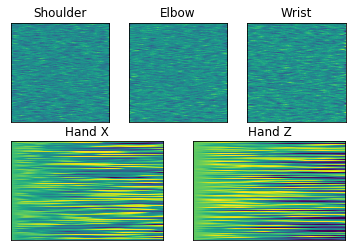

In [4]:
def auto_show_img(image, subplot, label):
    pyplot.subplot(subplot)
    pyplot.imshow(image, aspect='auto', interpolation='nearest', )
    pyplot.title(label)
    pyplot.xticks([])
    pyplot.yticks([])

pyplot.figure()
auto_show_img(alljoints[:,:250], 231, 'Shoulder')
auto_show_img(alljoints[:,250:500], 232, 'Elbow')
auto_show_img(alljoints[:,500:], 233, 'Wrist')
auto_show_img(allhands[:,:250], 223, 'Hand X')
auto_show_img(allhands[:,250:], 224, 'Hand Z')

In [5]:
numpy.save('joints.npy', alljoints)
numpy.save('hands.npy', allhands)

Trajectories might give a bit more insight. On the left are the first 5 trajectories, illustrating the nested circular paths characteristic of the 3-joint arm. On the right is a 2-dimensional histogram (a density plot) for all 5000 trajectories. Occupancy of the reachable space is somewhat biased towards the starting point and the edges.

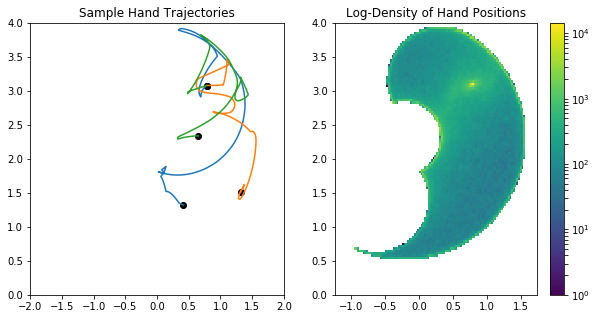

In [6]:
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
i = numpy.random.randint(0, 5000, (3))
pyplot.plot(allhands[i,:250].transpose(), allhands[i,250:].transpose())
pyplot.scatter(allhands[i,0].transpose(), allhands[i,250].transpose(), color='k')
pyplot.scatter(allhands[i,249].transpose(), allhands[i,499].transpose(), color='k')
pyplot.title('Sample Hand Trajectories')
pyplot.xlim(-2, 2)
pyplot.ylim(0, 4)

pyplot.subplot(122)
allx = allhands[:,:250].reshape((-1))
ally = allhands[:,250:].reshape((-1))
from matplotlib.colors import LogNorm
pyplot.hist2d(allx, ally, bins=100, norm=LogNorm())
pyplot.title('Log-Density of Hand Positions')
pyplot.xlim(-1.25, 1.75)
pyplot.ylim(0, 4)
pyplot.colorbar()

Finally, we can use cross-correlation to try and visualize linear effects of joint effort on hand position. We know that the true effects should be nonlinear, but over small windows of time and space, we might still see a linear relationship.

Below we calculate the lagged correlation coefficients of each trajectory for each joint on the stepwise difference in each component of the position.

In [7]:
def lagged_corrcoef(a, b, maxlag):
    coefs = numpy.zeros((a.shape[0],maxlag))
    for i in range(a.shape[0]):
        for lag in range(maxlag):
            coefs[i,lag] = numpy.corrcoef(a[i,:b.shape[1]-lag], b[i,lag:])[1,0]
    return coefs

# Using more rows to calculate the correlations takes longer
rows = numpy.random.permutation(alljoints.shape[0])[:500]
dx = numpy.diff(allhands[:,:250], axis=1)
dy = numpy.diff(allhands[:,250:], axis=1)
ax = lagged_corrcoef(alljoints[rows,:250], dx[rows,:], 248)
ay = lagged_corrcoef(alljoints[rows,:250], dy[rows,:], 248)
bx = lagged_corrcoef(alljoints[rows,250:500], dx[rows,:], 248)
by = lagged_corrcoef(alljoints[rows,250:500], dy[rows,:], 248)
cx = lagged_corrcoef(alljoints[rows,500:], dx[rows,:], 248)
cy = lagged_corrcoef(alljoints[rows,500:], dy[rows,:], 248)

Next we can average the correlation coefficients across rows and then plot those to see the effect in time of a nudge to any of the joints. For long lags, there are fewer points to calculate the correlation, so the values will be noisier.

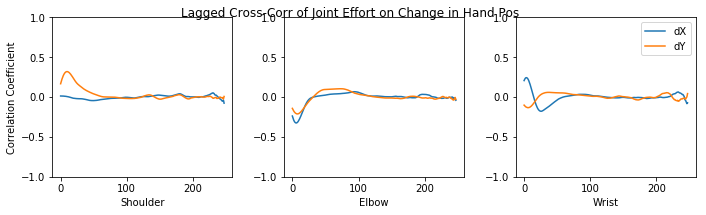

In [8]:
pyplot.figure(figsize=(10,3))
pyplot.suptitle('Lagged Cross-Corr of Joint Effort on Change in Hand Pos')
pyplot.subplot(131)
pyplot.plot(ax.mean(axis=0))
pyplot.plot(ay.mean(axis=0))
pyplot.xlabel('Shoulder')
pyplot.ylabel('Correlation Coefficient')
pyplot.ylim(-1,1)
pyplot.subplot(132)
pyplot.plot(bx.mean(axis=0))
pyplot.plot(by.mean(axis=0))
pyplot.xlabel('Elbow')
pyplot.ylim(-1,1)
pyplot.subplot(133)
pyplot.plot(cx.mean(axis=0), label='dX')
pyplot.plot(cy.mean(axis=0), label='dY')
pyplot.xlabel('Wrist')
pyplot.ylim(-1,1)
pyplot.legend()
pyplot.tight_layout()

Clearly, none of the joints has a very strong linear effect on the position of the hand, but there is some indication of the underlying dynamics. The very slow effects (greater than 1s) are probably due to autocorrelation in the joint efforts.

## Learning the Motor Transfer Function

Now that the data are loaded and we have completed preliminary exploration, we can try to learn the transfer function for joint efforts to hand positions.

In [9]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    numpy.random.seed(seed)

## Simple Model: Dense1 (250 ReLU)
After extensive model exploration, many architectural features of dense networks have no or even negative effects on performance. Network depth seems unimportant, except that greater than 3 layers is detrimental within the training regime used. Fewer than 100 units is inadequate, and greater than 500 slows training substantially and improves only test error, not train error.

The most important features are a high rate of dropout and small batches.

Ultimately, the best performing dense network was a single layer of 250 ReLU units, 50% dropout, 100 epochs with batch size 10, and decaying learning rate from 0.05.

In [57]:
reset_graph()
n_inputs = 3 * 250 # Joints * Samples
n_dense1 = 1000
n_outputs = 2 * 250 # Dimensions * Samples

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
Y = tf.placeholder(tf.float32, shape=(None), name='Y')
drop = tf.placeholder_with_default(0.0, shape=(), name='drop')

with tf.name_scope('dnn'):
    vsi_init = tf.contrib.layers.variance_scaling_initializer()
    drop_x = tf.layers.dropout(X, drop)
    dense1 = tf.layers.dense(drop_x, n_dense1, activation=tf.nn.relu,
                             kernel_initializer=vsi_init, name='dense1')
    drop1 = tf.layers.dropout(dense1, drop)
    Y_pred = tf.layers.dense(drop1, n_outputs, name='outputs')

The network is trained by minimizing the mean squared error of the predicted hand trajectories using gradient descent and an annealed learning rate.

80% of the simulation data is assigned to the training set. Input data are scaled to have mean 0 and variance 1.

In [58]:
# Setup the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(alljoints, allhands, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

For each epoch, training data are randomly assigned to batches before invoking the training operation. After training, the train and test error are evaluated on the full datasets. Finally, after training completes, predictions are generated for each row of the test dataset.

In [62]:
# Define the loss function, optimizer, and training regime
def train_model(inputs, outputs, targets, n_epochs=100, batch_size=10,
                initial_lr=0.05, drop_rate=0.5):
    
    # Create the MSE loss function
    with tf.name_scope('loss'):
        mse = tf.losses.mean_squared_error(targets, outputs)
        loss = tf.reduce_mean(mse, name='loss')
    
    # Create a decaying learning rate which starts at initial_lr and decays by 1% per epoch
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_lr, batch * batch_size,
                                               X_train.shape[0], 0.99)
    
    # Create an optimizer and training operation
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss, global_step=batch)
    
    # Run the training model
    epoch_mse = numpy.zeros((n_epochs, 2))
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            shuffled_indices = numpy.random.permutation(X_train.shape[0])
            for b in range(X_train.shape[0] // batch_size):
                batch = shuffled_indices[b * batch_size:(b + 1) * batch_size]
                X_batch = X_train[batch,:]
                Y_batch = Y_train[batch,:]
                sess.run(training_op, feed_dict={drop: drop_rate, X: X_batch, Y: Y_batch})
            epoch_mse[epoch,0] = loss.eval(feed_dict={X: X_train, Y: Y_train})
            epoch_mse[epoch,1] = loss.eval(feed_dict={X: X_test, Y: Y_test})
            print '.',
        predictions = outputs.eval(feed_dict={X: X_test})
        return epoch_mse, predictions

dense1_mse, dense1_predictions = train_model(X, Y_pred, Y)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Plot the mean squared error of the train and test dataset for each training epoch.

Train Error: 0.0677239000797    Test Error: 0.248338848352


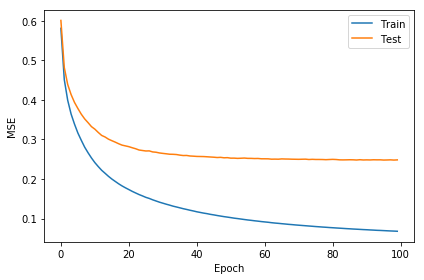

In [60]:
def plot_mse(mse):
    print('Train Error: {}    Test Error: {}'.format(mse[-1,0],
                                                     mse[-1,1]))
    pyplot.figure()
    pyplot.plot(mse[:,0], label='Train')
    pyplot.plot(mse[:,1], label='Test')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MSE')
    pyplot.legend()
    pyplot.tight_layout()

plot_mse(dense1_mse)

Plot the predicted (**blue**) and actual (**orange**) trajectories for X (**top**) and Y (**bottom**) coordinates. Labels above each column correspond to row MSE, left are the best 3 predictions in the dataset and right are the best 3 predictions.

Final error for the simple model is reasonably good. Train error is roughly 1/3rd of test error, however, indicating some overfitting has occurred.

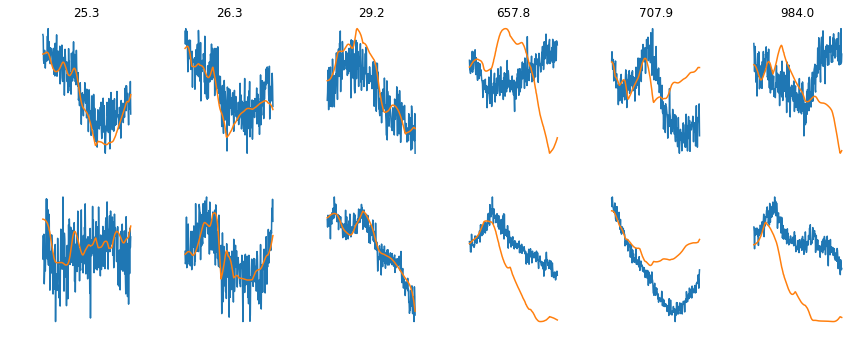

In [61]:
def plot_predictions(targets, predictions):
    row_mse = ((targets - predictions) ** 2).sum(axis=1)
    order = numpy.argsort(row_mse)
    best_and_worst = [0, 1, 2, 997, 998, 999]
    targets = targets[order,:][best_and_worst,:]
    predictions = predictions[order,:][best_and_worst,:]
    row_mse = row_mse[order][best_and_worst]
    pyplot.figure(figsize=(12,5))
    plot_num = 1
    for i in range(predictions.shape[0]):
        pyplot.subplot(2, 6, plot_num)
        pyplot.plot(predictions[i,:250])
        pyplot.plot(targets[i,:250])
        pyplot.title('{:.1f}'.format(row_mse[i]))
        pyplot.axis('off')
        plot_num += 1
    for i in range(predictions.shape[0]):
        pyplot.subplot(2, 6, plot_num)
        pyplot.plot(predictions[i,250:])
        pyplot.plot(targets[i,250:])
        pyplot.axis('off')
        plot_num += 1
    pyplot.tight_layout()

plot_predictions(Y_test, dense1_predictions)

While the best reconstructions demonstrate reasonably good fit overall, there is significant high frequency noise in the predictions. The worst reconstructions do not fit either the low frequency or high frequency movement.

## Best Model: Conv2 (400 ReLU conv2d > 250 ReLU)
As in the dense networks, model performance for convolutional networks is more sensitive to training parameters than architectural parameters, except that there is a clear benefit of relatively long temporal convolutions.

The best performing model was still relatively simple: a single 2d convolutional layer of 2000 ReLU units consisting of 16 3x50 filters (spanning all three joints and 1s of simulation time), connected to an average-pooling layer which downsamples in time by a factor of 5, connected to a single dense layer of 250 ReLU units. Inputs, pooled outputs, and dense outputs all have 50% dropout applied

In [21]:
reset_graph()
n_joints = 3
n_samples = 250
n_inputs = n_joints * n_samples
n_c1filt = 16
c1_kernel = (3,50)
c1_stride = (3,2)
p1_kernel = (1,5)
p1_stride = (1,5)
n_pool1 = 400
n_dense1 = 250
n_outputs = 2 * 250 # Dimensions * Samples

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
Y = tf.placeholder(tf.float32, shape=(None), name='Y')
drop_rate = tf.placeholder_with_default(0.0, shape=(), name='drop_rate')

with tf.name_scope('dnn'):
    vsi_init = tf.contrib.layers.variance_scaling_initializer()
    # Input dropout significantly reduces high-frequency noise
    drop1 = tf.layers.dropout(X, drop_rate)
    reshape_x = tf.reshape(drop1, (-1, n_joints, n_samples, 1))
    # Convolutional layer using ReLU and variance scaling initializer
    conv1 = tf.layers.conv2d(reshape_x,
                             filters=n_c1filt,
                             kernel_size=c1_kernel,
                             strides=c1_stride,
                             padding='SAME',
                             kernel_initializer=vsi_init,
                             activation=tf.nn.relu)
    # Average pooling layer provides the mean activation of each filter
    # over 200 ms.
    pool1 = tf.layers.average_pooling2d(conv1,
                                        pool_size=p1_kernel,
                                        strides=p1_stride)
    # Flatten the pooling layer output to feed into the dense layer
    pool1_flat = tf.reshape(pool1, (-1, n_pool1))
    drop2 = tf.layers.dropout(pool1_flat, drop_rate)
    dense1 = tf.layers.dense(drop2,
                             n_dense1,
                             activation=tf.nn.relu,
                             kernel_initializer=vsi_init,
                             name='dense1')
    drop3 = tf.layers.dropout(dense1, drop_rate)
    Y_pred = tf.layers.dense(drop3, n_outputs, name='outputs')

With more parameters, the Conv2 model takes somewhat longer to train, and also exhibits less overfitting, indicating that there will be more benefit to training after 100 epochs.

In [33]:
conv2_mse, conv2_predictions = train_model(X, Y_pred, Y, n_epochs=150)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Train Error: 0.110919326544    Test Error: 0.128231495619


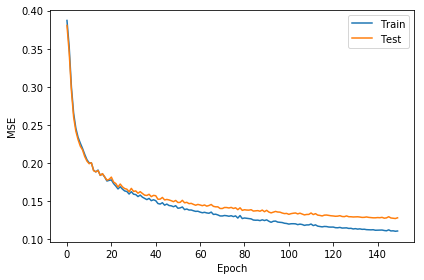

In [35]:
plot_mse(conv2_mse)

Test error is still decreasing after 150 epochs, but not fast enough to make much difference in prediction quality.

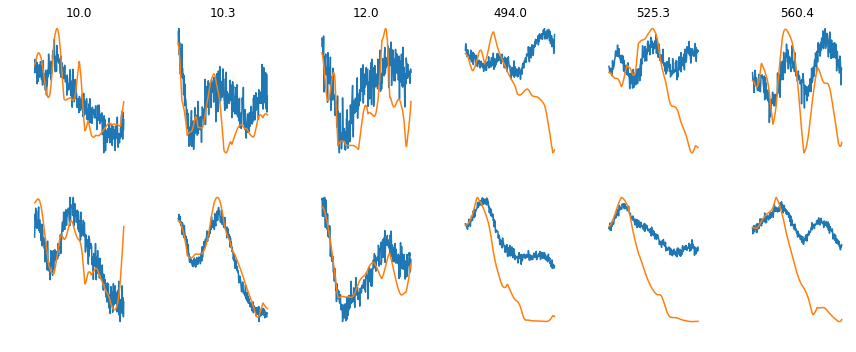

In [37]:
plot_predictions(Y_test, conv2_predictions)

While MSE for the Conv2 model is better overall than the for the Dense1 model, predictions are not visibly better